In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from utils.preprocessing import create_time_matrix, create_caregivers_df, create_tasks_df, create_clients_df

caregivers = create_caregivers_df('data/raw/caregivers.csv')

tasks = create_tasks_df('data/raw/hemtjanst_tasks.csv', only_client_tasks=True)

clients = create_clients_df('data/raw/clients.csv')

drive_time_matrix = create_time_matrix('data/raw/duration_matrix_DRIVE.csv')
walk_time_matrix = create_time_matrix('data/raw/duration_matrix_WALK.csv')
bicycle_time_matrix = create_time_matrix('data/raw/duration_matrix_BICYCLE.csv')

In [ ]:
# Test1: Subset with only caregivers 33, 949, 1108 and their tasks
test1_subset = [33, 949, 1108]
test_caregivers = caregivers.loc[test1_subset]
test_tasks = tasks[tasks['PlannedCaregiverID'].isin(test1_subset)]

# Test2: Subset with only first 10 caregivers that use car as mode of transport
car_caregivers = caregivers[caregivers['ModeOfTransport'] == 'car'].head(10)
car_tasks = tasks[tasks['PlannedCaregiverID'].isin(car_caregivers.index)]

In [8]:
from models.basic_flexible_model import BasicFlexibleModel
from models.basic_fixed_model import BasicFixedModel
from models.break_fixed_model import BreakFixedModel
model_type = BreakFixedModel
model_caregivers = car_caregivers
model_tasks = car_tasks

model = model_type(model_caregivers, model_tasks, clients, drive_time_matrix, walk_time_matrix, bicycle_time_matrix)
model.build()
model.optimize(TimeLimit=1000)

Created variables.
Created objective function.
Model built with break constraints.
Set parameter TimeLimit to value 1000
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  1000

Optimize a model with 5687 rows, 440691 columns and 2007222 nonzeros
Model fingerprint: 0xf197dff7
Model has 432480 simple general constraints
  432480 INDICATOR
Variable types: 34 continuous, 440657 integer (440657 binary)
Coefficient statistics:
  Matrix range     [3e-03, 1e+03]
  Objective range  [1e+00, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
  GenCon rhs range [2e-02, 9e+02]
  GenCon coe range [3e+01, 3e+01]
Presolve added 274844 rows and 8758 columns
Presolve time: 0.35s
Presolved: 280531 rows, 449449 columns, 1266686 nonzeros
Variable types: 240504 continuous, 208945 integer (200614 binary)
Performin

<gurobi.Model MIP instance HomeCare: 5687 constrs, 440691 vars, Parameter changes: TimeLimit=1000.0, Username=(user-defined), LicenseID=2635249>

Model not optimally solved. Status: 9


/Users/vilhelmkarlin/Code/KTH/SA120X_KEX/utils/visualization.py:521: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  dashboard_fig.show()


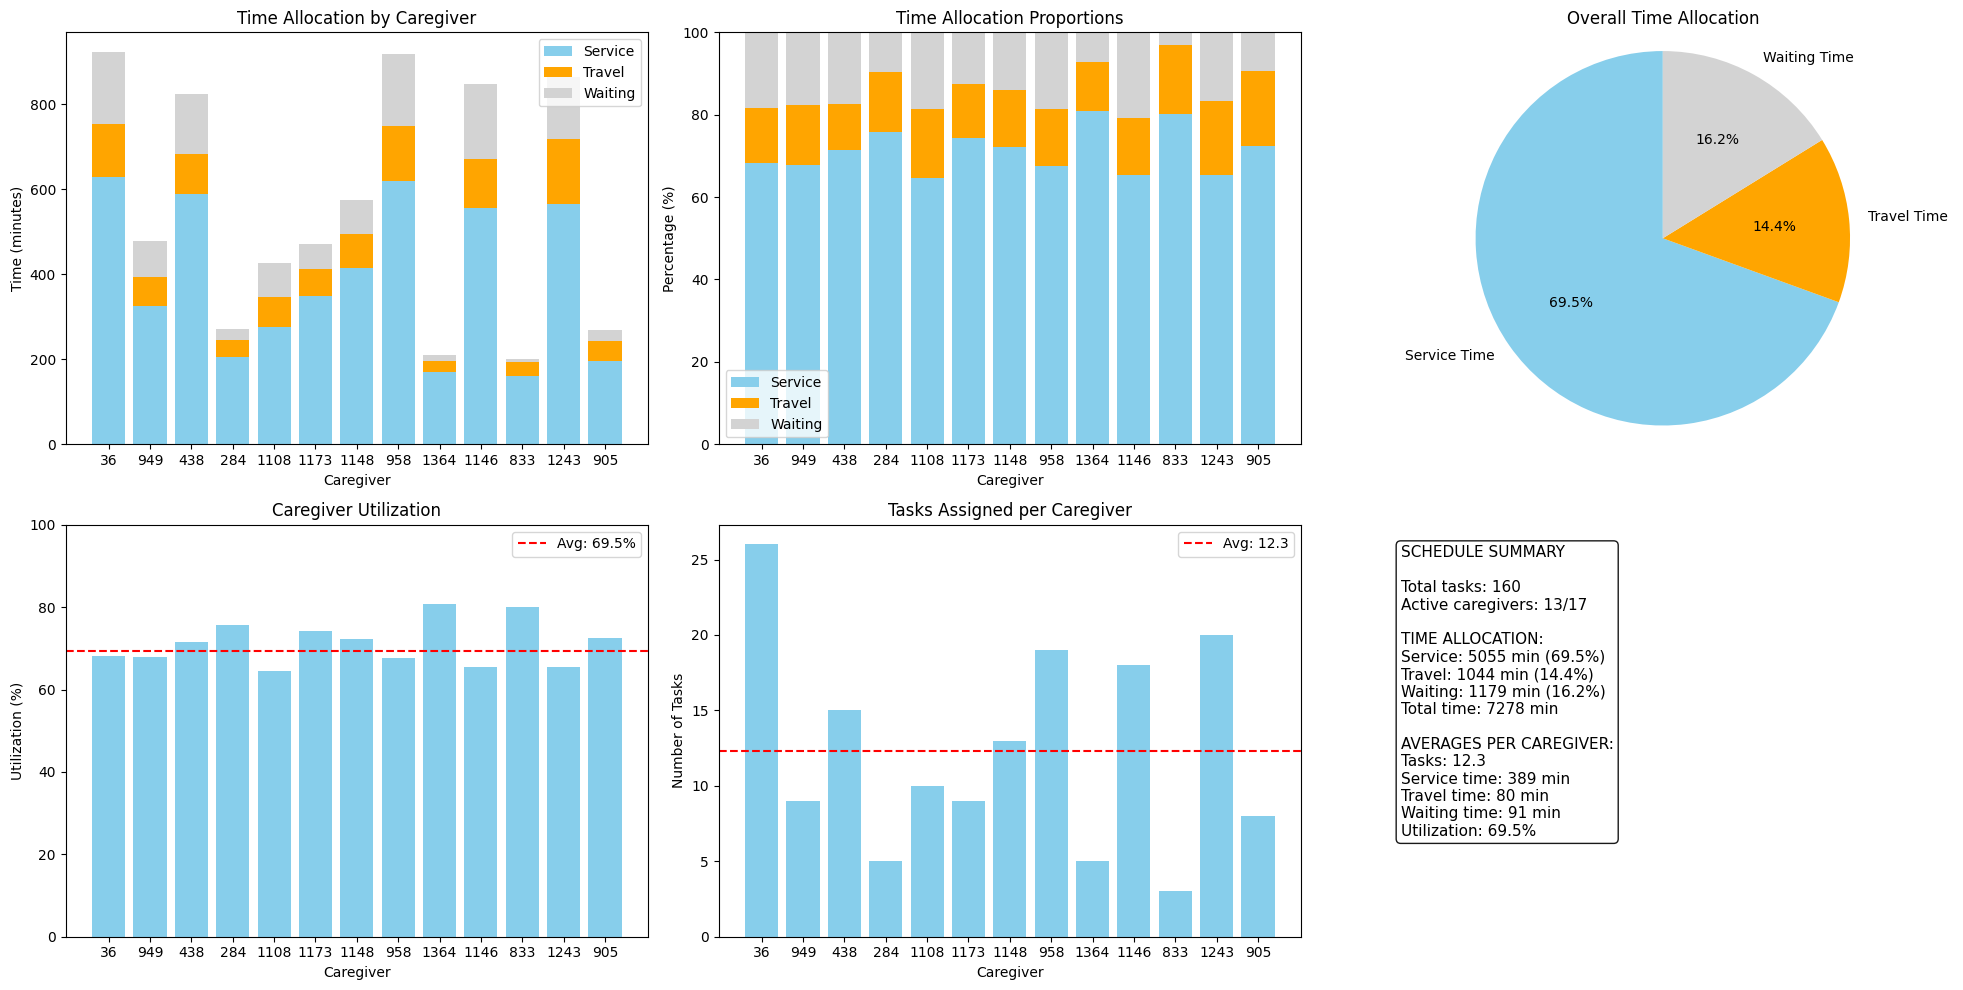

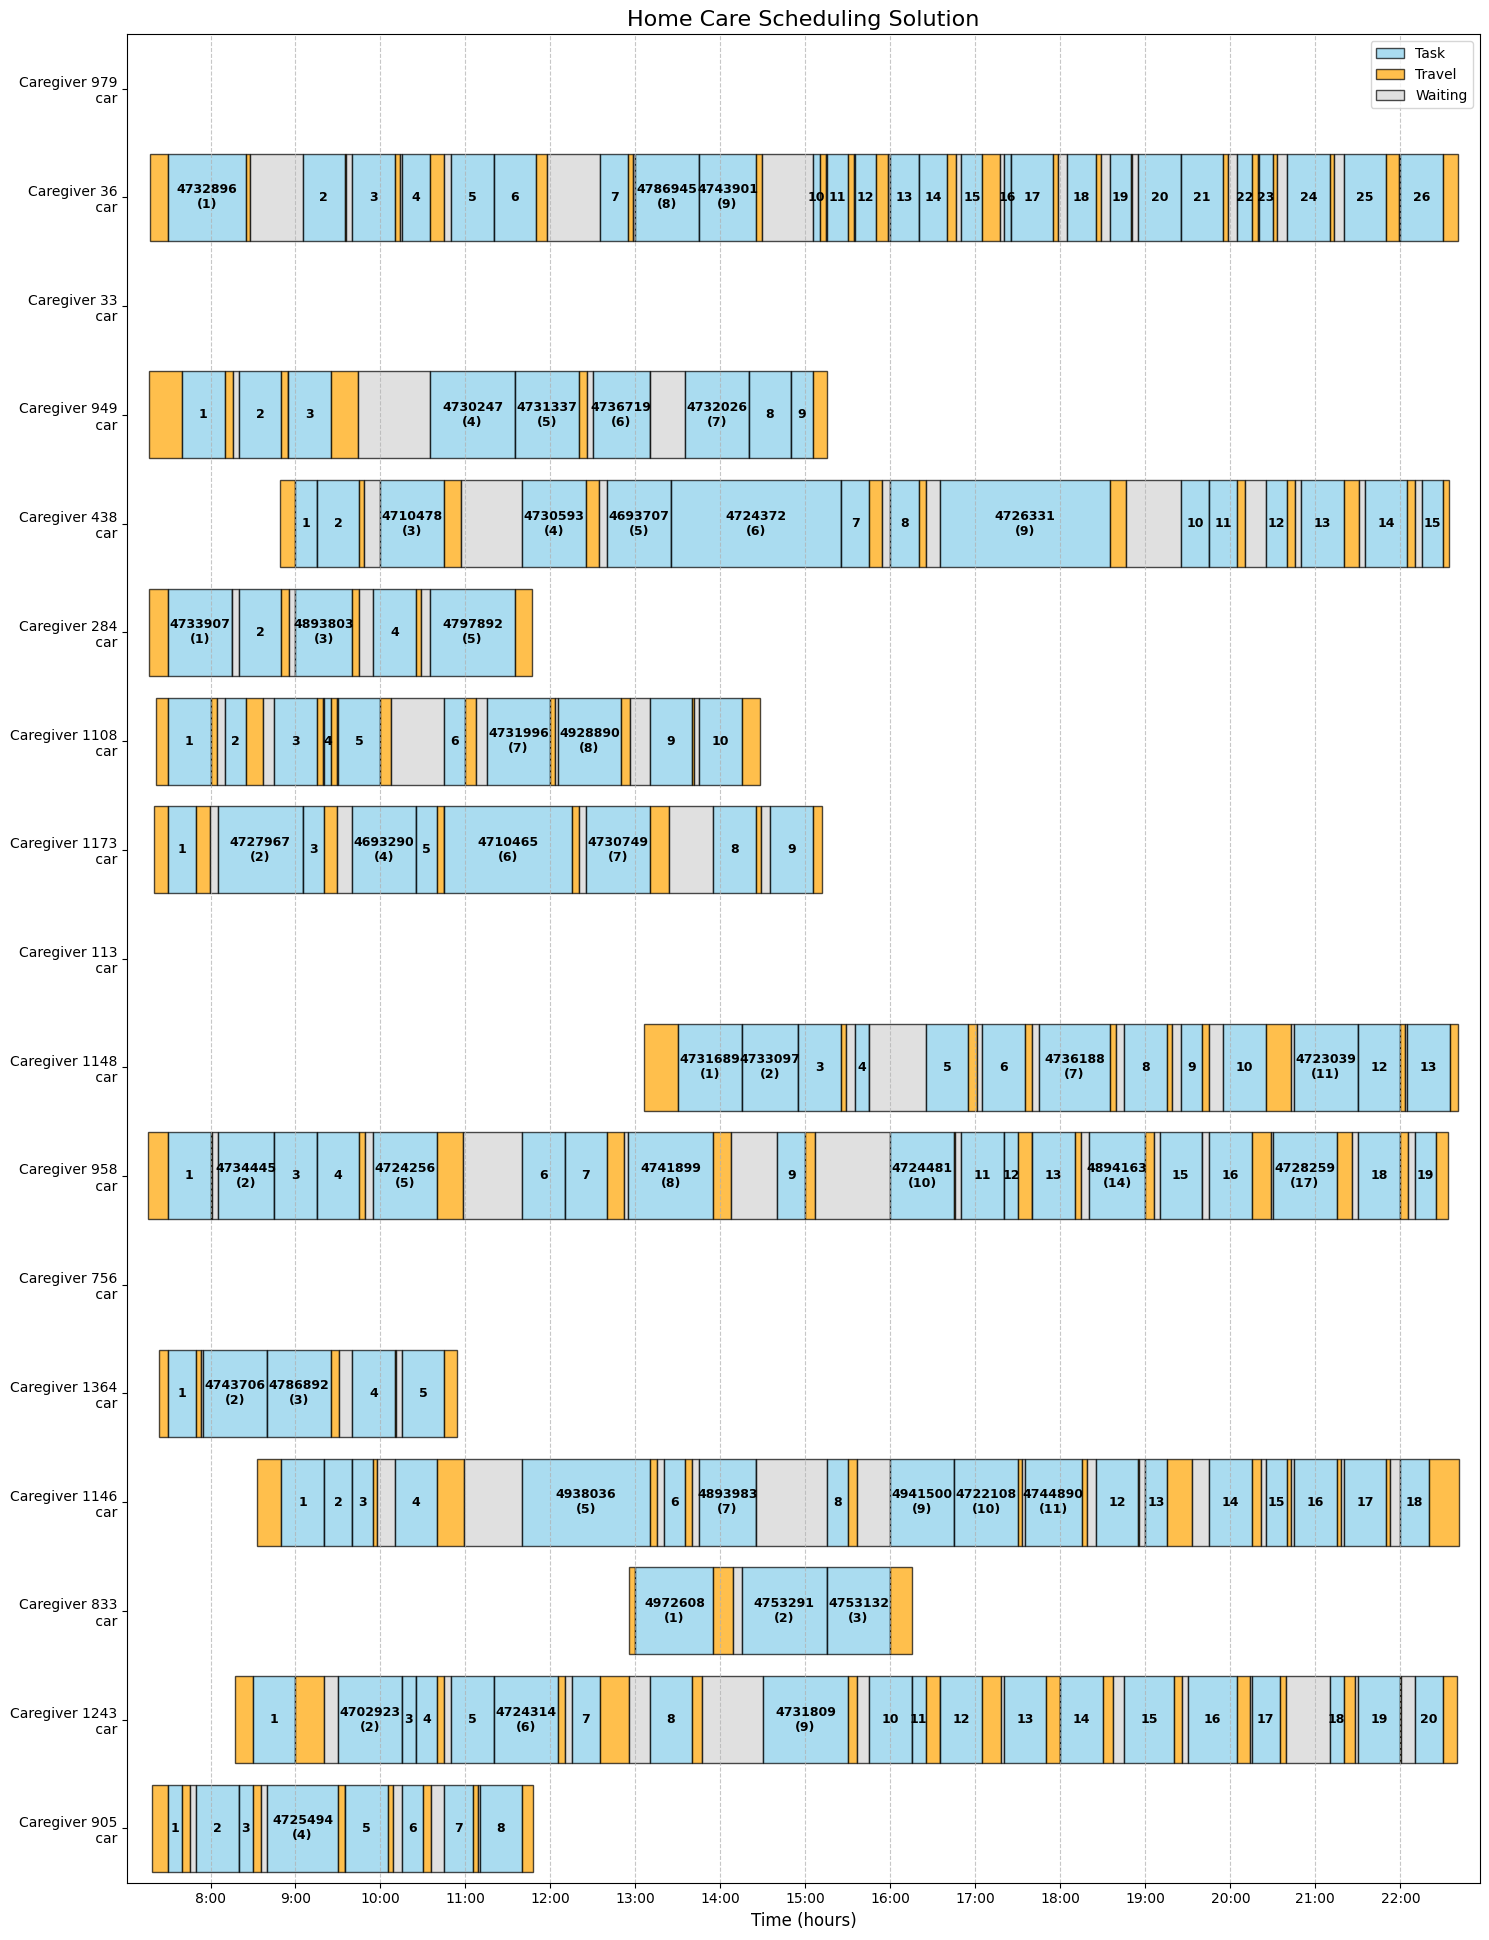

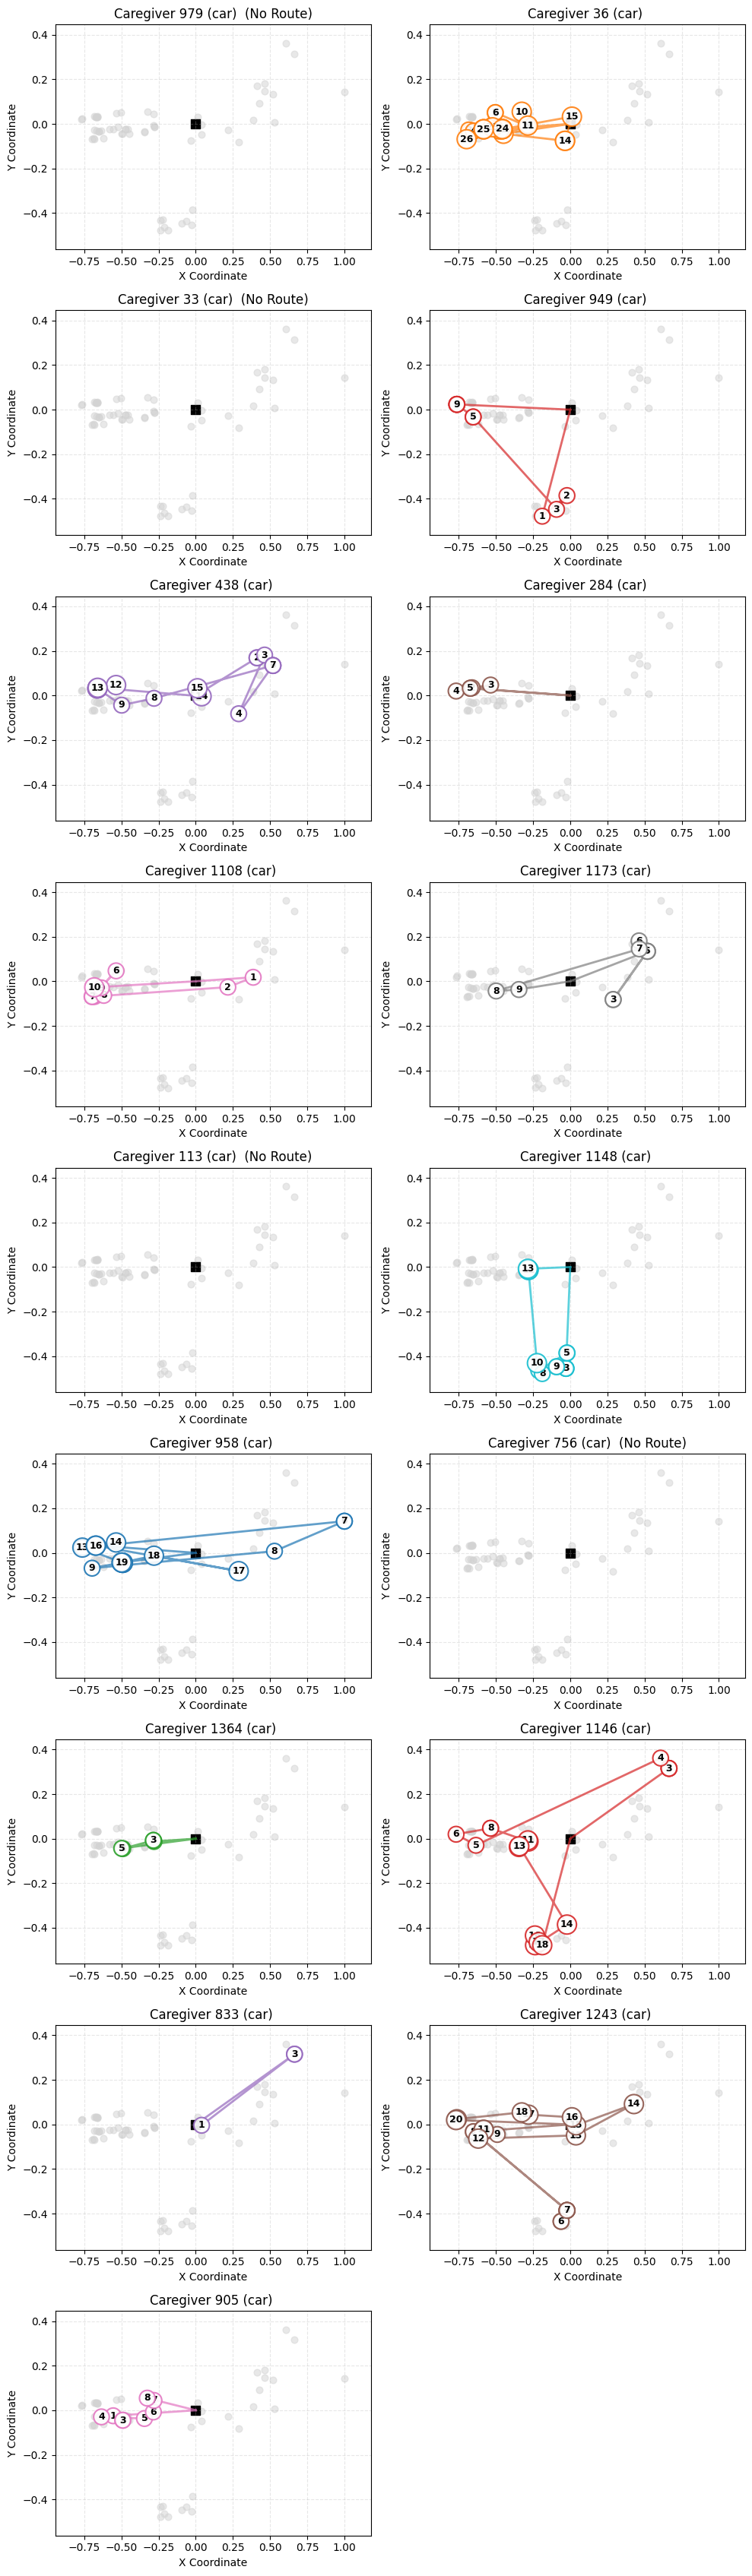

In [9]:
from utils.visualization import visualize_schedule, visualize_metrics, visualize_routes

model.get_solution()

visualize_metrics(model, display_mode='dashboard');
visualize_schedule(model);
visualize_routes(model, caregiver_ids=None, subplot_mode=True);

In [ ]:
for k in model.K:
    breaks = sum([model.B[k, i].X for i in model.V])
    shift_length = model.T[k, "end"].X - model.T[k, "start"].X
    print(f"\nCaregiver {k}")
    print(f"Shift length: {shift_length}")
    print(f"Breaks: {breaks}")
    print(f"Minimum breaks: {shift_length/(60*5)-1}")

print(list(enumerate(model.routes[1108])))
print(model.arrivals[1108])



Caregiver 33
Shift length: 536.2833333333333
Breaks: 1.0
Minimum breaks: 0.787611111111111

Caregiver 949
Shift length: 270.65
Breaks: 0.0
Minimum breaks: -0.09783333333333344

Caregiver 1108
Shift length: 516.1166666666668
Breaks: 1.0
Minimum breaks: 0.7203888888888892
[(0, ('start', 4721787)), (1, (4721787, 4722509)), (2, (4722509, 4725494)), (3, (4725494, 4730354)), (4, (4730354, 4728298)), (5, (4728298, 4938036)), (6, (4938036, 4852582)), (7, (4852582, 4735265)), (8, (4735265, 4731809)), (9, (4731809, 4937903)), (10, (4937903, 'end'))]
{'start': 441.46666666666664, 'end': 957.5833333333334, 4721787: np.int32(450), 4722509: np.int32(490), 4725494: np.int32(520), 4730354: np.int32(580), 4728298: np.int32(615), 4938036: np.int32(700), 4852582: np.int32(790), 4735265: np.int32(835), 4731809: np.int32(870), 4937903: np.int32(935)}


In [ ]:
print(model.e[4885503])
print(model.l[4728298] + model.c[33, 4728298, 4885503])
print(model.l[4728298] + model.c[33, 4728298, 4885503] - model.e[4885503])

700
664.05
-35.950000000000045


In [ ]:
(model.T[1108, "end"].X - model.T[1108, "start"].X) / (60*5) - 1

model.e[4885503] - model.l[4728298] - model.c[33, 4728298, 4885503] - model.break_length

np.float64(5.950000000000003)